# 0. Imports

In [23]:
from pathlib import Path

from flax.training import train_state
from jax import jit, value_and_grad, vmap
import jax.numpy as jnp
import jax.random as jr
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import optax
import pandas as pd
import tensorflow_probability.substrates.jax as tfp
import wfdb

from mlscience_ekgs.settings import mimic_note_path, mimic_ecg_path
from mlscience_ekgs.Code.src.s01_data_loader import load_12ch_data

tfd = tfp.distributions
MVN = tfd.MultivariateNormalTriL
MVD = tfd.MultivariateNormalDiag
Normal = tfd.Normal

In [2]:
mms = pd.read_csv(
    Path(mimic_ecg_path, "machine_measurements.csv"),
)

/var/folders/tw/jx7fnz115r58vjdhf2nly6z9bk7mxt/T/ipykernel_10903/1235998378.py:1: DtypeWarning: Columns (16,17,18,19,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  mms = pd.read_csv(


In [10]:
# Total number of rows
print(f"{'Num rows':<30}: {mms.shape[0]:,}")

# Bradycardia: y=0
print(f"{'Num rows with bradycardia':<30}: {mms.report_0.str.contains('bradycardia').sum():,}")

# Tachycardia: y=1
print(f"{'Num rows with tachycardia':<30}: {mms.report_0.str.contains('tachycardia').sum():,}")

Num rows                      : 800,035
Num rows with bradycardia     : 99,235
Num rows with tachycardia     : 69,334


In [83]:
def create_mimic_filepath(subject_id, study_id):
    subject_id, study_id = str(subject_id), str(study_id)
    patient_id_prefix = subject_id[:4]
    study_filepath = Path(
        mimic_ecg_path, "files", f"p{patient_id_prefix}",
        f"p{subject_id}", f"s{study_id}", study_id
    )
    
    return study_filepath
    

def load_mimic_data(subject_id, study_id):
    ecg_filepath = create_mimic_filepath(subject_id, study_id)
    channel_data, metadata = wfdb.rdsamp(ecg_filepath)
    channel_data = channel_data.T
    channels = metadata["sig_name"]
    
    return channel_data, channels

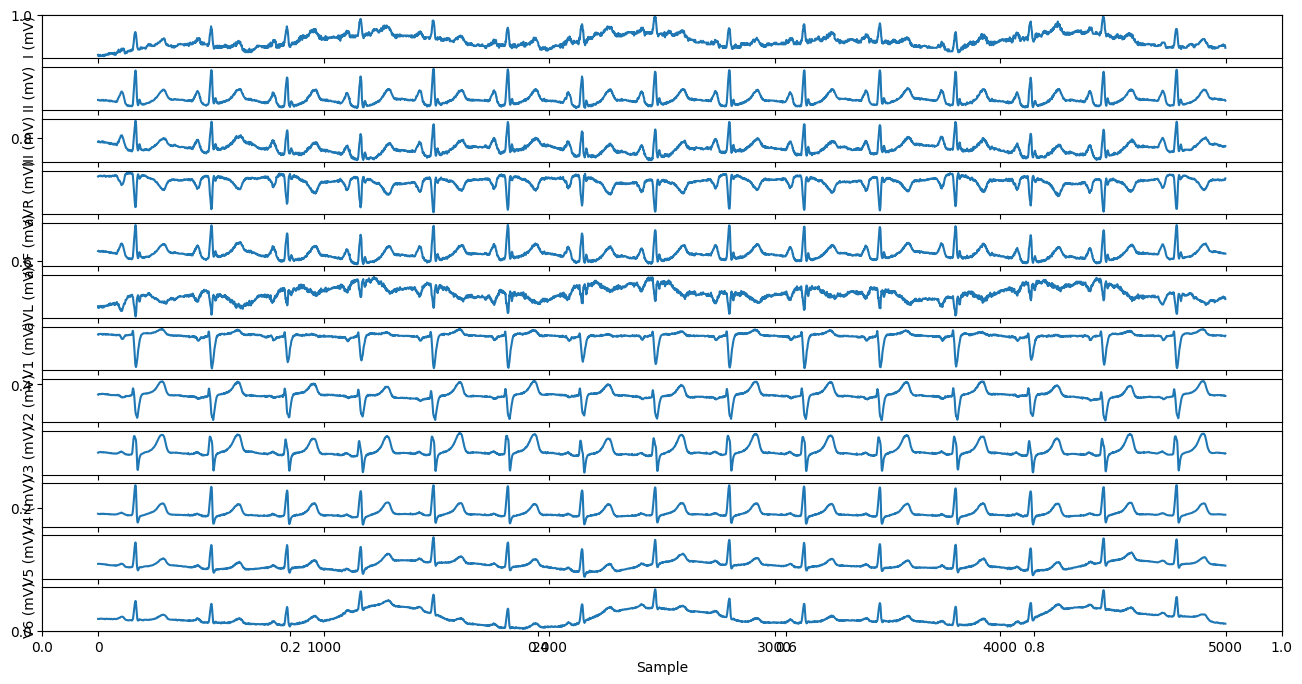

In [58]:
# Plot random ECG
channel_data, channels = load_mimic_data("10000032", "40689238")

fig, ax = plt.subplots(figsize=(16, 8))
gs = gridspec.GridSpec(12, 1, height_ratios=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

# Create each subplot
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1], sharex=ax0)
ax2 = plt.subplot(gs[2], sharex=ax0)
ax3 = plt.subplot(gs[3], sharex=ax0)
ax4 = plt.subplot(gs[4], sharex=ax0)
ax5 = plt.subplot(gs[5], sharex=ax0)
ax6 = plt.subplot(gs[6], sharex=ax0)
ax7 = plt.subplot(gs[7], sharex=ax0)
ax8 = plt.subplot(gs[8], sharex=ax0)
ax9 = plt.subplot(gs[9], sharex=ax0)
ax10 = plt.subplot(gs[10], sharex=ax0)
ax11 = plt.subplot(gs[11], sharex=ax0)
axes = [ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11]


for i, (ax, data) in enumerate(zip(axes, channel_data)):
    ax.plot(data)
    ax.set_ylabel(f"{channels[i]} (mV)")
    ax.set_yticks([])
    ax.set_xlabel("Sample");

# 1. Bradycardia vs tachycardia

In [65]:
df_b = mms[mms.report_0.str.contains("bradycardia", na=False)][["subject_id", "study_id"]].reset_index(drop=True)
df_t = mms[mms.report_0.str.contains("tachycardia", na=False)][["subject_id", "study_id"]].reset_index(drop=True)

In [90]:
# ECG data with bradycardia
X_b = []
for index, row in df_b.iterrows():
    subject_id, study_id = row
    try:
        curr_data, _ = load_mimic_data(subject_id, study_id)
        X_b.append(curr_data)
    except:
        print(f"Error loading data for subject_id={subject_id}, study_id={study_id}")
        continue
X_b = jnp.array(X_b)

In [ ]:
# ECG data with tachycardia
X_t = []
for index, row in df_t.iterrows():
    subject_id, study_id = row
    try:
        curr_data, _ = load_mimic_data(subject_id, study_id)
        X_t.append(curr_data)
    except:
        print(f"Error loading data for subject_id={subject_id}, study_id={study_id}")
        continue
X_t = jnp.array(X_t)

In [89]:
X_b.shape

(10, 12, 5000)

In [ ]:
def load_12ch_data(data_idx=0, starting_idx=0, length=10_000, channels=CHANNELS):
    """Load 12-lead ECG data from the PTB database.
    
    Args:
        data_idx: index of the data file to load.
        starting_idx: index of the starting sample.
        length: number of samples to load.
        
    Returns:
        channel_data: 12-lead ECG data.
    """
    with open(Path(ptb_path, "RECORDS")) as fp:
        data_list = fp.readlines()
    
    curr_data = data_list[data_idx].strip()
    channel_data, _ = wfdb.rdsamp(Path(ptb_path, curr_data), channel_names=channels)
    channel_data = channel_data.T
    channel_data = channel_data[:, starting_idx:starting_idx+length]
    
    return channel_data

In [42]:
with open(Path(mimic_ecg_path, "files")) as fp:
    data_list = fp.readlines()

IsADirectoryError: [Errno 21] Is a directory: '/Users/peterchang/Desktop/Repos/mlscience-ekgs/mlscience_ekgs/Data/mimic-iv-ecg/files'

In [29]:
ecg_path = Path(mimic_ecg_path, "files", "p1000", "p10000032", "s40689238", "40689238")

In [38]:
channel_data, metadata = wfdb.rdsamp(ecg_path)
channel_data = channel_data.T

In [39]:
channels = metadata["sig_name"]

In [40]:
channel_data.shape

(12, 5000)

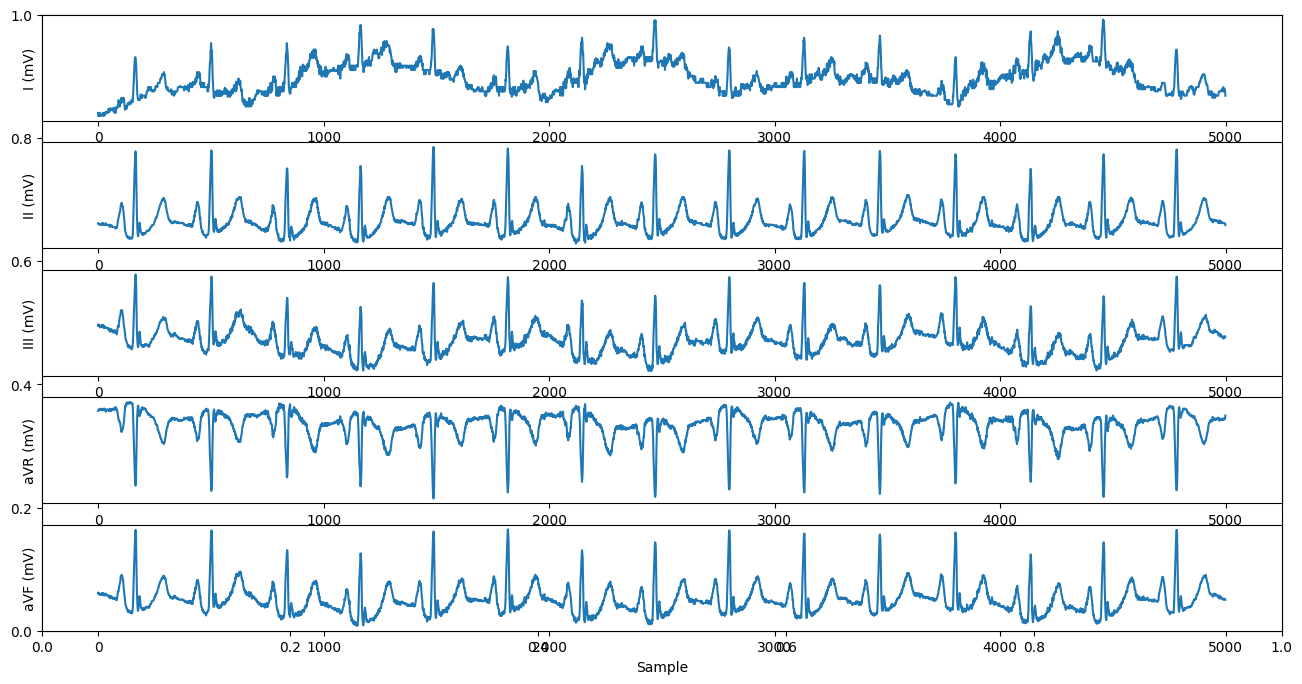

In [41]:
fig, ax = plt.subplots(figsize=(16, 8))
gs = gridspec.GridSpec(5, 1, height_ratios=[1, 1, 1, 1, 1])

# Create each subplot
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1], sharex=ax0)
ax2 = plt.subplot(gs[2], sharex=ax0)
ax3 = plt.subplot(gs[3], sharex=ax0)
ax4 = plt.subplot(gs[4], sharex=ax0)
axes = [ax0, ax1, ax2, ax3, ax4]


for i, (ax, data) in enumerate(zip(axes, channel_data[:5])):
    ax.plot(data)
    ax.set_ylabel(f"{channels[i]} (mV)")
    ax.set_yticks([])
    ax.set_xlabel("Sample");